## 🔑 OpenAI API Key

In [24]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_API_KEY")

## 📚 Imports

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from IPython.display import display

import traceback
import re # To clean the LLM Output

## 📥 Load datasets


In [26]:
yt_df = pd.read_csv("data/youtube_data.csv")
rd_df = pd.read_csv("data/reddit_data.csv")

## 🧹 Previews


In [27]:
print("🎥 YouTube data shape:", yt_df.shape)
print("📕 Reddit data shape:", rd_df.shape)

🎥 YouTube data shape: (25, 6)
📕 Reddit data shape: (61, 13)


## 🎯 Aggregated Sentiment Analysis


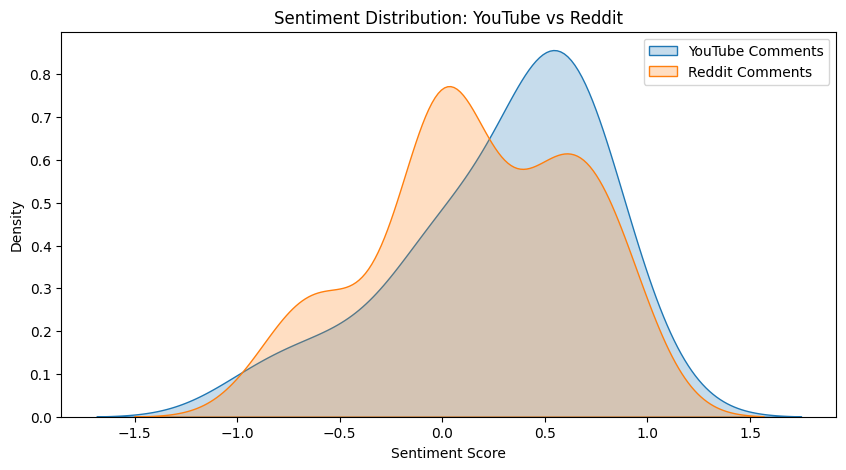

In [29]:
# Create plot
plt.figure(figsize=(10, 5))
sns.kdeplot(yt_df['comment_sentiment'], label='YouTube Comments', fill=True)
sns.kdeplot(rd_df['comment_sentiment'], label='Reddit Comments', fill=True)
plt.title('Sentiment Distribution: YouTube vs Reddit')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()

# ✅ Save BEFORE showing (Otherwise, a blank image will be saved)
plt.savefig("data/sentiment_distribution.png", bbox_inches="tight")

# Then show (for notebook preview)
plt.show()
plt.close()


## 📊 Average Sentiment Comparison


In [6]:
avg_sentiments = pd.DataFrame({
    'Platform': ['YouTube', 'Reddit'],
    'Avg Comment Sentiment': [yt_df['comment_sentiment'].mean(), rd_df['comment_sentiment'].mean()]
})
display(avg_sentiments)

,Platform,Avg Comment Sentiment
0,YouTube,0.189296
1,Reddit,0.166679


## 🧠 Create grouped summaries for LLM


In [12]:
# Instantiating OpenAI
client = OpenAI(api_key=OPENAI_KEY)

In [13]:
topics = yt_df['video_title'].unique()
final_outputs = []

for topic in topics:
    yt_comments = yt_df[yt_df['video_title'] == topic]['comment'].dropna().tolist()
    reddit_rows = rd_df[rd_df['youtube_title'] == topic]
    reddit_post = reddit_rows['reddit_post_title'].unique()[0] if not reddit_rows.empty else "No Reddit post found"
    reddit_comments = reddit_rows['comment'].dropna().tolist()

    if not yt_comments and not reddit_comments:
        continue

    # ✅ Cleaned, limited comments for brevity
    yt_sample = "\n- ".join(yt_comments[:3])
    rd_sample = "\n- ".join(reddit_comments[:3])

    # ✅ Full prompt passed to model
    user_prompt = f"""
Video Title: {topic}
Reddit Post Title: {reddit_post}

🟦 YouTube Comments:
- {yt_sample}

🟥 Reddit Comments:
- {rd_sample}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are a social media analyst. Analyze public perception around this topic using the comments from YouTube and Reddit. Provide a concise summary and highlight any sentiment trends or contrasting opinions between platforms."
                },
                {
                    "role": "user",
                    "content": user_prompt.strip()
                }
            ],
            temperature=0.7
        )
        output = response.choices[0].message.content
    except Exception as e:
        output = f"⚠️ Error for topic: {topic} | {str(e)}"
        print(traceback.format_exc())

    final_outputs.append({
        "topic": topic,
        "reddit_post_title": reddit_post,
        "llm_analysis": output
    })

## 📋 Show results

In [14]:
llm_df = pd.DataFrame(final_outputs)

# Using Regular Expressions to clean the LLM Output
def clean_llm_output(text):
    # Remove Markdown bold/italic
    text = re.sub(r"\*\*(.*?)\*\*", r"\1", text)
    text = re.sub(r"\*(.*?)\*", r"\1", text)
    # Remove Headers
    text = re.sub(r"\#+", r"", text)
    # Remove newlines and excessive spacing
    text = re.sub(r"\n+", "\n", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip()

# Applying the cleaning function to the 'llm_analysis' column
llm_df['llm_analysis'] = llm_df['llm_analysis'].apply(clean_llm_output)

llm_df.head()

,topic,reddit_post_title,llm_analysis
0,Brawl Talk: A NEW BRAWLER RARITY?!,A NEW BRAWLER RARITY?! Brawl Talk is tomorrow!,"Based on the YouTube and Reddit comments, publ..."
1,"$1 vs $25,000 Build Challenge",Bloons TD 6 v48.0 - Update Notes!,Summary:\nYouTube Comments:\nThe comments on t...
2,Doechii - Anxiety (Official Video),Doechii - Anxiety (Official Music Video),"Based on the comments from YouTube and Reddit,..."
3,THE GASLIGHT DISTRICT: PILOT,With the Pilot of the Gaslight District releas...,"The public perception of ""The Gaslight Distric..."
4,"Remontada épica. Abajo por 2 goles, el Barcelo...",Post-Match Thread: FC Barcelona vs Celta Vigo ...,The public perception of the match between FC ...


In [15]:
for llm_analysis in llm_df['llm_analysis']:
    print(llm_analysis, end="\n\n\n")

Based on the YouTube and Reddit comments, public perception around the announcement of a new brawler rarity in Brawl Stars is generally positive and filled with anticipation.
YouTube Sentiment:
The comments on YouTube are overwhelmingly positive. Viewers express enjoyment and appreciation for the video, with remarks indicating that it brought happiness and provided valuable insights. This suggests that the Brawl Talk video was well-received and effectively communicated the intended excitement about the new content.
Reddit Sentiment:
On Reddit, the discussion is more speculative and analytical. Users are engaging in predictions and theories about the new brawler's characteristics and storyline. The comment mentioning "RYAN IS BACK BABY" reflects excitement, likely referring to a beloved figure within the Brawl Stars community. However, the presence of automated moderation comments indicates a need for structured discussion and adherence to community guidelines, which may limit the type 

## Saving to csv

In [16]:
os.makedirs("data", exist_ok=True)
llm_df.to_csv("data/llm_insights.csv", index=False)